## Convocatoria 1 - Proyecto 1

In [1]:
# imports
from skimage import data, io, filters, morphology
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

#### 0) Cargar una de las imágenes histológicas

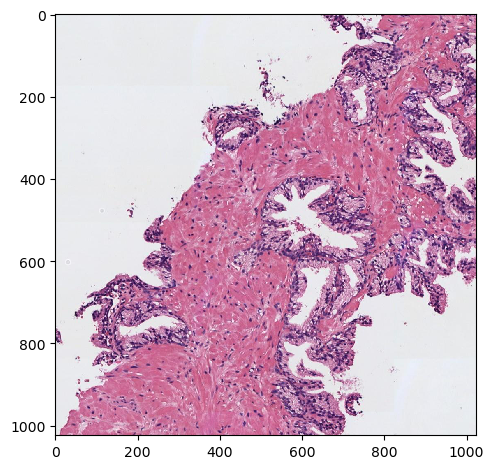

In [2]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
img = io.imread('histo_1.jpg')

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
img = img/np.max(img)

# Visualizar la imagen
io.imshow(img);

#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

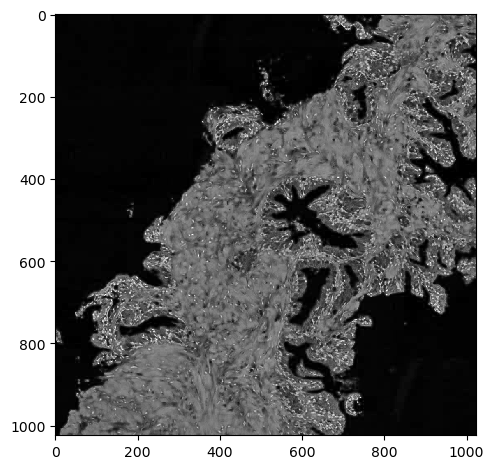

In [3]:
rgb = img.copy()
K = 1 - np.max(rgb, axis = 2)
C = (1 - rgb[:, :, 0] - K)/(1 - K)
M = (1 - rgb[:, :, 1] - K)/(1 - K)
Y = (1 - rgb[:, :, 2] - K)/(1 - K)
CMYK = (np.dstack((C,M,Y,K))*255).astype('uint8')

# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
img_mag = M.copy()

# Visualizar la imagen del canal magenta
io.imshow(img_mag);

#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

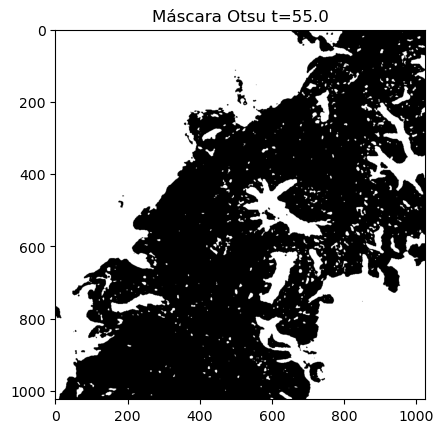

In [4]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

# Filtro gaussiano
img_gaus = cv2.GaussianBlur(img_mag, (5,5), 0)*255
img_gaus = img_gaus.astype('uint8')

# Método de Otsu
t, mask = cv2.threshold(img_gaus, 0, 1, cv2.THRESH_OTSU) # 0 es por defecto y 1 es el valor máximo de la máscara
mask = (1 - mask).astype('uint8') # inversión binaria

# Visualizar la máscara resultante
plt.imshow(mask, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show();

#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

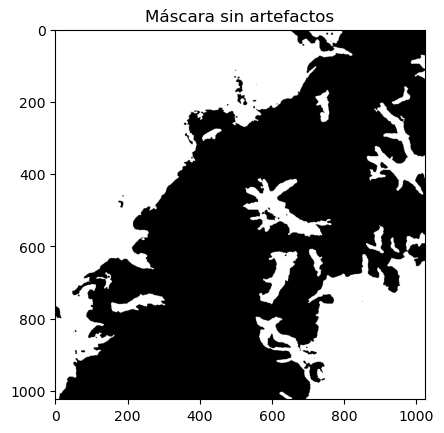

In [10]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
mask_clean = morphology.remove_small_objects(mask.astype(bool), min_size=300).astype('uint8')

# Visualizaer la máscara resultante
plt.imshow(mask_clean, cmap='gray')
plt.title('Máscara sin artefactos')
plt.show();

#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

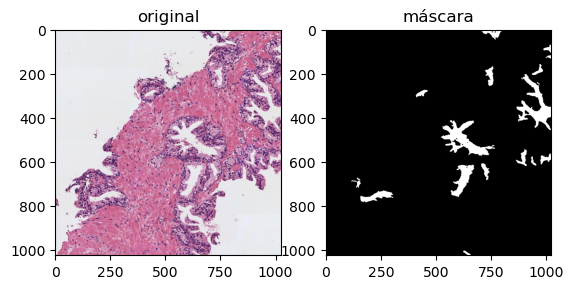

In [12]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
mask_copy = mask_clean.copy()

# Definir una imagen negra de referencia
h, w = mask_copy.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijar las semillas. En este caso en la esquina superior izquierda (posición 0,0) y otra en la esquina inferior 
# derecha, para rellenar a partir de ahí
cv2.floodFill(mask_copy, ref, (0,0), 0)
cv2.floodFill(mask_copy, ref, (h-2,w-2), 0)

fig, ax = plt.subplots(1,2)
ax[0].imshow(img, cmap='gray'), ax[0].set_title('original')
ax[1].imshow(mask_copy, cmap='gray'), ax[1].set_title('máscara')
plt.show()

# Visualizar la máscara resultante. 

#### 5) Rellenar los objetos de los lúmenes

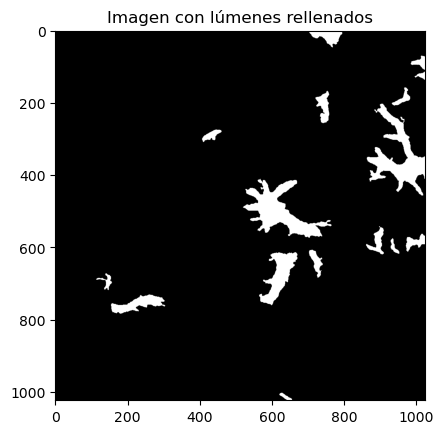

In [14]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
from scipy.ndimage import binary_fill_holes
mask_filled = binary_fill_holes(mask_copy)

# Visualizar la máscara resultante
plt.imshow(mask_filled, cmap='gray')
plt.title('Imagen con lúmenes rellenados')
plt.show();

#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


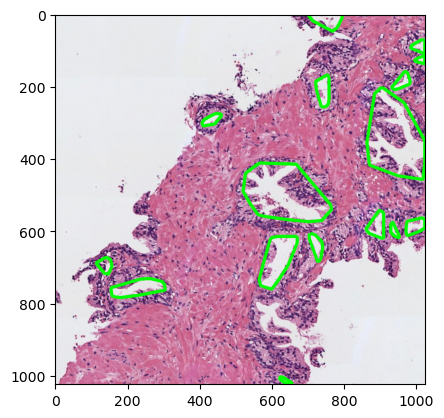

In [16]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles.

# Convertimos la imagen binaria en una imagen de etiquetas para tener acceso a cada objeto por separado
from skimage.measure import label

lab, num = label(mask_filled, return_num=True)

from skimage.morphology import convex_hull_image
from skimage.measure import regionprops


# Repetimos el proceso completo para todos los objetos de la imagen
imagen = img.copy()
for i in range(1, num+1): 
    objeto = lab == i
    objeto = objeto.astype('uint8')
    convex_image = convex_hull_image(objeto)
    convex_image = convex_image.astype('uint8')
    conts,_ = cv2.findContours(convex_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen = cv2.drawContours(imagen, conts, -1, (0,255,0), 8)

plt.imshow(imagen, cmap='gray')
plt.show();

#### 7) Identificar y cropear el lumen más grande

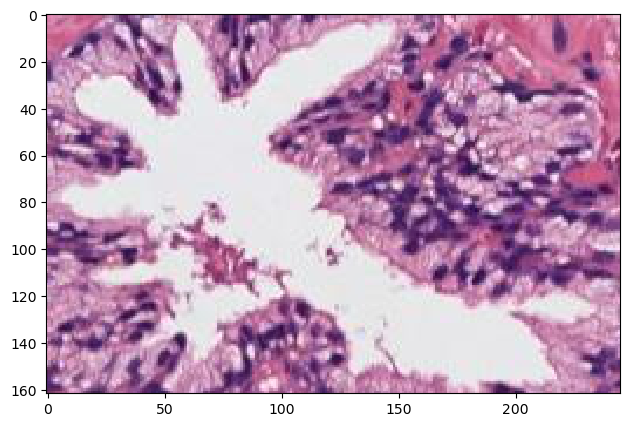

In [59]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
conts,_ = cv2.findContours(mask_filled.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def get_contour_areas(contours):

    all_areas= []

    for cnt in contours:
        area= cv2.contourArea(cnt)
        all_areas.append(area)

    return all_areas

max_contour_index = np.argmax(get_contour_areas(conts))
max_contour = conts[max_contour_index]
x_max_bound, y_max_bound = tuple(np.amax(conts[max_contour_index], axis = 0).reshape((2)))
x_min_bound, y_min_bound = tuple(np.amin(conts[max_contour_index], axis = 0).reshape((2)))
biggest_lumen = img[y_min_bound:y_max_bound, x_min_bound:x_max_bound]

# Visualizar el lumen cropeado.
io.imshow(biggest_lumen);

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [60]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
area = cv2.contourArea(max_contour)
print("El área del mayor lumen es: " + str(area))
# 2) Área de la bounding box
area = cv2.contourArea(max_contour)
print("El área de su bounding box es :" + str(area))
# 3) Área convexa

# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

El área del mayor lumen es:13545.5


In [57]:
from tabulate import tabulate
import math

new_lab, new_num = label(mask_filled, return_num=True)

# Extraemos las característicias geométricas
headers = ['','Raro', 'Rayo', 'Círculo', 'Cuadrado', 'Triángulo', 'Rombo']
A,BB,CA,E,ED,EX,MA,MiA,OR,P,S,CO,R = ['area'], ['bbox_area'], ['convex_area'], ['eccentricity'], ['equiv_diameter'], \
['extent'], ['major_axis'], ['minor_axis'], ['orientation'], ['perimeter'], ['solidity'], ['compactness'], ['rectangularity']

for i in range(1,new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    
    A.append(np.round(prop[0].area, 4))
    BB.append(np.round(prop[0].bbox_area, 4))
    CA.append(np.round(prop[0].convex_area, 4))
    E.append(np.round(prop[0].eccentricity, 4))
    ED.append(np.round(prop[0].equivalent_diameter, 4))
    EX.append(np.round(prop[0].extent, 4))
    MA.append(np.round(prop[0].major_axis_length, 4))
    MiA.append(np.round(prop[0].minor_axis_length, 4))
    OR.append(np.round(prop[0].orientation, 4))
    P.append(np.round(prop[0].perimeter, 4))
    S.append(np.round(prop[0].solidity, 4))
    CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
    R.append(np.round(prop[0].area/prop[0].bbox_area, 4))


my_data = [tuple(A), tuple(BB), tuple(CA), tuple(E), tuple(ED), tuple(EX), \
          tuple(MA), tuple(MiA), tuple(OR), tuple(P), tuple(S), tuple(CO), tuple(R)]

print(tabulate(my_data, headers=headers))

/var/folders/pj/92ywdssd5gn5df54rtb8kjg40000gn/T/ipykernel_7298/805808106.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  CO.append(np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4))
